# Libraries

In [1]:
import sys
sys.path.append("./")
from utils import train_test_split

from tqdm.auto import tqdm 
tqdm.pandas()
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split
# from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder
from sklearn.ensemble import RandomForestRegressor

# Preprocessing

In [2]:
DATA = "data/"

data = pd.read_csv(DATA + "fact_train_test.csv", sep=";")
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,"71,0",1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,"210,0",3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,"67,0",1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,"67,0",1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,"66,0",1
...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,"69,0",1
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,"70,0",1
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,"70,0",1
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,"207,0",3


In [3]:
data["period"] = pd.to_datetime(data["period"])
data["real_weight"] = data["real_weight"].apply(lambda x: float(x.replace(",", ".")))
data = data[data["real_weight"] >= 0]
data = data.sort_values(by="period")

data.shape

(3559215, 11)

In [4]:
data = data[data["period"] > datetime.datetime(2017, 1, 1)]
data.shape

(3514465, 11)

# FE 

In [5]:
datetime_columns = ["period"]

In [6]:
def add_time_series_features(df, data_cols=['period']):
    features = []
    for col in datetime_columns:
        features.extend([col + "_year", col + "_day", col + "_weekday", col + "_month"])
        df[col] = df[col].fillna(df[col].mode())
        df[col] = pd.to_datetime(df[col], format="%Y-%m-%d",errors='coerce')
        df[col + "_year"] = df[col].dt.year
        df[col + "_day"] = df[col].dt.day
        df[col + "_weekday"] = df[col].dt.weekday
        df[col + "_month"] = df[col].dt.month
        df[col + "_seconds"] = df[col].apply(lambda x: (x - datetime.datetime(1970, 1, 1)).total_seconds())
    return df, features


def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    client_mapping_file = "./data/client_mapping.csv"
    freight_mapping_file = "./data/freight_mapping.csv"
    station_mapping_file = "./data/station_mapping.csv"
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df


data, cat_datetime_fe = add_time_series_features(data)
data = add_master_data_mappings(data)
data["holding_name"] = data["holding_name"].fillna(-1).astype("int")

In [7]:
date_min = data["period"].min()
date_max = data["period"].max()
data["months_from_start"] = (data["period"].dt.year - date_min.year) * 12 + (data["period"].dt.month - date_min.month)
period = data["period"]
data = data.drop(columns=["period"])
data

,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,...,period_weekday,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,months_from_start
0,1,5,1,-1,1682,12676,12195,3464,128.0,2,...,2,2,1.485907e+09,-1,39,36,4,54,4,0
1,1,5,1,-1,1682,12676,12195,5244,68.0,1,...,2,2,1.485907e+09,-1,39,36,4,54,4,0
2,1,5,1,-1,1682,12676,35462,5244,39.0,1,...,2,2,1.485907e+09,-1,39,36,4,104,10,0
3,1,5,1,-1,1682,38063,33596,9075,62.0,1,...,2,2,1.485907e+09,-1,39,18,9,141,29,0
4,1,5,1,-1,1682,12676,28542,3464,64.0,1,...,2,2,1.485907e+09,-1,39,36,4,134,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514460,0,2,2,2129,1697,35809,30792,25817,194.0,3,...,2,3,1.677629e+09,519,39,79,10,2,12,73
3514461,0,2,2,2129,1697,35809,31112,25817,65.0,1,...,2,3,1.677629e+09,519,39,79,10,4,12,73
3514462,0,2,2,2129,1708,35667,38470,25817,659.0,10,...,2,3,1.677629e+09,519,39,79,10,76,6,73
3514463,0,2,2,2129,2120,35809,36430,25817,66.0,1,...,2,3,1.677629e+09,519,14,79,10,8,16,73


In [8]:
data.isnull().sum()

rps                          0
podrod                       0
filial                       0
client_sap_id                0
freight_id                   0
sender_station_id            0
recipient_station_id         0
sender_organisation_id       0
real_weight                  0
real_wagon_count             0
period_year                  0
period_day                   0
period_weekday               0
period_month                 0
period_seconds               0
holding_name                 0
freight_group_name           0
sender_department_name       0
sender_railway_name          0
recipient_department_name    0
recipient_railway_name       0
months_from_start            0
dtype: int64

# Model

In [9]:
# train_test = train_test_split(data, group_columns=["rps", "holding_name", "sender_department_name", "recipient_department_name"])
# train, test = train_test[train_test["is_test"] == False], train_test[train_test["is_test"] == True]
# train, test = train.drop(columns=["is_test"]), test.drop(columns=["is_test"])
# train_test

In [10]:
data.shape

(3514465, 22)

In [11]:
test_dates = set(data["months_from_start"].unique()[-5:])
is_test = data["months_from_start"].progress_apply(lambda x: x in test_dates)
data["is_test"] = is_test
data["is_test"].sum(), data["is_test"].shape[0] - data["is_test"].sum()

  0%|          | 0/3514465 [00:00<?, ?it/s]

(218828, 3295637)

In [12]:
train, test = data[data["is_test"] == False], data[data["is_test"] == True]
train, test = train.drop(columns=["is_test"]), test.drop(columns=["is_test"])
train.shape, test.shape

((3295637, 22), (218828, 22))

In [13]:
train = train.drop(columns=["real_weight"])
test = test.drop(columns=["real_weight"])

In [14]:
X_train, X_test, y_train, y_test = train.drop(columns=["real_wagon_count"]), test.drop(columns=["real_wagon_count"]), train["real_wagon_count"], test["real_wagon_count"]
X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]

(3295637, 218828, 3295637, 218828)

In [15]:
categorical_features =["rps", "podrod", "filial", "client_sap_id", "freight_id", "sender_station_id", "recipient_station_id", "sender_organisation_id"] + \
cat_datetime_fe + \
['recipient_department_name', 'recipient_railway_name', 'sender_department_name', 'sender_railway_name', "freight_group_name", "holding_name"]

categorical_features

['rps',
 'podrod',
 'filial',
 'client_sap_id',
 'freight_id',
 'sender_station_id',
 'recipient_station_id',
 'sender_organisation_id',
 'period_year',
 'period_day',
 'period_weekday',
 'period_month',
 'recipient_department_name',
 'recipient_railway_name',
 'sender_department_name',
 'sender_railway_name',
 'freight_group_name',
 'holding_name']

In [16]:
numeric_features = ['months_from_start', 'period_seconds']
numeric_features

['months_from_start', 'period_seconds']

In [18]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", CatBoostEncoder(cols=categorical_features)),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("Scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("linear", RandomForestRegressor(random_state=42, verbose=2))]
)

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  ['months_from_start',
                                                   'period_seconds']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   CatBoostEncoder(cols=['rps',
                                                                                         'podrod',
                                                                                         'filial',
                                                                                         'client_sap_id',
                                                                                         'freight_id',
                                                                                         'sender_station_id',
                                                                                         'recipient_station_id',
                                                                                         'sender_organisation_id',
                                                                                         'period_year',
                                                                                         'p...
                                                   'client_sap_id',
                                                   'freight_id',
                                                   'sender_station_id',
                                                   'recipient_station_id',
                                                   'sender_organisation_id',
                                                   'period_year', 'period_day',
                                                   'period_weekday',
                                                   'period_month',
                                                   'recipient_department_name',
                                                   'recipient_railway_name',
                                                   'sender_department_name',
                                                   'sender_railway_name',
                                                   'freight_group_name',
                                                   'holding_name'])])),
                ('linear', RandomForestRegressor(random_state=42, verbose=2))])

In [ ]:
%%time
model.fit(
    X_train,
    y_train
)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 67.7min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


In [ ]:
import numpy as np
preds = model.predict(X_test)
preds[preds < 0] = 0
preds

In [ ]:
sns.displot(preds, bins=100)

In [ ]:
X_test.shape[0], preds[preds < 0].shape,  preds[preds > 0].shape

In [ ]:
X_test

# Evaluate

In [ ]:
import numpy as np


def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"
    if public:
        metric_weight = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
    else:
        metric_weight = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    # fact = add_master_data_mappings(fact)
    # forecast = add_master_data_mappings(forecast)

    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    score = (
        summary["Forecast Accuracy"].sort_index(ascending=True) * metric_weight
    ).sum()

    return score


def calc_score_public(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=True)


def calc_score_private(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=False)

In [ ]:
preds

In [ ]:
fact = X_test.copy()
fact["real_wagon_count"] = y_test
fact["period"] = list(period[is_test == True])
fact = fact[fact["real_wagon_count"] > 0]

In [ ]:
forecast = X_test.copy()
forecast["forecast_wagon_count"] = preds
forecast["period"] = list(period[is_test == True])
forecast = forecast[forecast["forecast_wagon_count"] > 0]

In [ ]:
forecast

In [ ]:
# Скорим
score_public = calc_score_public(fact, forecast)
score_private = calc_score_private(fact, forecast)
print(f"Public score: {score_public}")
print(f"Private score: {score_private}")

С отрицательными значениями: 
Public score: 0.6031490080789712
Private score: 0.41790083598674166

Предикты меньше 0 заменить 0
Public score: 0.6159311265690937
Private score: 0.562187435265229

Все записи, где 0 дропнуть
Public score: 0.6159311265690937
Private score: 0.562187435265229

Фичи с весом 1 вагона:
Public score: 0.6140041549902395
Private score: 0.557186562527978

# Final Model

In [30]:
X, y = data.drop(columns=["real_wagon_count", "is_test", "real_weight"]), data["real_wagon_count"]
X

(3559215, 23)
(2080150, 23)


/home/leffff/PycharmProjects/data-wagon/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solo_wagons['weight_per_wagon'] = solo_wagons['real_weight']/solo_wagons['real_wagon_count']
/home/leffff/PycharmProjects/data-wagon/utils.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solo_wagons['weight_per_wagon'] = solo_wagons['weight_per_wagon'].fillna(solo_wagons['real_weight'])


,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,mean_weight,q95_weight
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,2012,...,7,1.341101e+09,1423,21,153,12,75,4,46.753924,70.0
1,2014-03-01,0,1,1,328,3472,30252,29548,10036,2014,...,3,1.393632e+09,1423,30,153,12,16,11,65.051321,68.0
2,2014-03-01,0,1,1,328,3472,30252,29158,10036,2014,...,3,1.393632e+09,1423,30,153,12,118,11,65.051321,68.0
3,2014-03-01,0,2,1,328,3472,30252,27484,10036,2014,...,3,1.393632e+09,1423,30,153,12,94,39,63.678005,67.0
4,2014-07-01,1,5,1,328,1193,30252,32471,10036,2014,...,7,1.404173e+09,1423,21,153,12,119,29,46.753924,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080145,2023-03-01,0,2,2,2129,1776,9390,32810,30685,2023,...,3,1.677629e+09,519,37,97,23,103,29,29.411588,67.0
2080146,2023-03-01,0,2,2,2129,1697,35809,30790,25817,2023,...,3,1.677629e+09,519,39,79,10,2,12,55.317423,67.0
2080147,2023-03-01,0,2,2,2129,1697,35809,31112,25817,2023,...,3,1.677629e+09,519,39,79,10,4,12,55.317423,67.0
2080148,2023-03-01,0,2,2,2129,2120,35809,36430,25817,2023,...,3,1.677629e+09,519,14,79,10,8,16,17.472902,66.0


In [31]:
params = model.get_all_params()
params["iterations"] = params["iterations"] + 100

In [32]:
new_params = {
    "iterations": params["iterations"],
    "depth":params["depth"],
    "learning_rate":params["learning_rate"],
    "random_seed":params["random_seed"],
    "task_type": params["task_type"],
}
new_params

{'iterations': 1100,
 'depth': 6,
 'learning_rate': 0.1407500058412552,
 'random_seed': 42,
 'task_type': 'GPU'}

In [33]:
final_model = CatBoostRegressor(
    **new_params
)

In [34]:
final_model.fit(
    X,
    y,
    cat_features=["rps", "podrod", "filial", "client_sap_id", "freight_id", "sender_station_id", "recipient_station_id", "sender_organisation_id"] + cat_datetime_fe,
)

0:	learn: 88.7115657	total: 40.9ms	remaining: 44.9s
1:	learn: 85.9186668	total: 83.9ms	remaining: 46.1s
2:	learn: 83.7654724	total: 120ms	remaining: 43.8s
3:	learn: 82.0210751	total: 150ms	remaining: 41.1s
4:	learn: 80.6689532	total: 186ms	remaining: 40.8s
5:	learn: 79.5786267	total: 219ms	remaining: 39.9s
6:	learn: 78.6477527	total: 257ms	remaining: 40.2s
7:	learn: 77.9860314	total: 284ms	remaining: 38.7s
8:	learn: 77.4265495	total: 316ms	remaining: 38.3s
9:	learn: 76.4893814	total: 347ms	remaining: 37.8s
10:	learn: 75.7611022	total: 374ms	remaining: 37s
11:	learn: 75.2034125	total: 411ms	remaining: 37.2s
12:	learn: 74.7816870	total: 450ms	remaining: 37.7s
13:	learn: 74.3696177	total: 479ms	remaining: 37.1s
14:	learn: 74.0250446	total: 514ms	remaining: 37.2s
15:	learn: 73.7470215	total: 548ms	remaining: 37.1s
16:	learn: 73.2945604	total: 579ms	remaining: 36.9s
17:	learn: 73.0666864	total: 612ms	remaining: 36.8s
18:	learn: 72.6491247	total: 640ms	remaining: 36.4s
19:	learn: 72.2463322	

In [35]:
forecast_example = pd.read_csv(DATA + "forecast_example.csv", sep=";").drop(columns=["forecast_wagon_count"])
forecast_example

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,"73,0"
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,"146,0"
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,"876,0"
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,"473,0"
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,"63,0"
...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,"69,0"
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,"70,0"
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,"70,0"
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,"207,0"


In [36]:
forecast_example["period"] = pd.to_datetime(forecast_example["period"])

forecast_example.shape

(239605, 10)

In [37]:
forecast_example, cat_datetime_fe = add_time_series_features(forecast_example)
forecast_example = add_master_data_mappings(forecast_example)
forecast_example["holding_name"] = forecast_example["holding_name"].fillna(-1).astype("int")

In [39]:
X_train

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,mean_weight,q95_weight
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,2012,...,7,1.341101e+09,1423,21,153,12,75,4,46.616097,70.0
1,2014-03-01,0,1,1,328,3472,30252,29548,10036,2014,...,3,1.393632e+09,1423,30,153,12,16,11,64.985009,68.0
2,2014-03-01,0,1,1,328,3472,30252,29158,10036,2014,...,3,1.393632e+09,1423,30,153,12,118,11,64.985009,68.0
3,2014-03-01,0,2,1,328,3472,30252,27484,10036,2014,...,3,1.393632e+09,1423,30,153,12,94,39,63.688499,67.0
4,2014-07-01,1,5,1,328,1193,30252,32471,10036,2014,...,7,1.404173e+09,1423,21,153,12,119,29,46.616097,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950496,2022-10-01,0,2,1,837,1041,33901,11223,26544,2022,...,10,1.664582e+09,2176,31,51,43,97,23,56.891203,68.0
1950497,2022-10-01,0,2,1,837,1041,33901,11195,26544,2022,...,10,1.664582e+09,2176,31,51,43,98,23,56.891203,68.0
1950498,2022-10-01,0,2,1,837,1041,33901,34208,26544,2022,...,10,1.664582e+09,2176,31,51,43,110,43,56.891203,68.0
1950499,2022-10-01,0,2,1,866,349,37358,38966,29645,2022,...,10,1.664582e+09,2192,10,55,3,23,6,55.518590,68.0


In [40]:
X.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'period_year', 'period_day', 'period_weekday', 'period_month',
       'period_seconds', 'holding_name', 'freight_group_name',
       'sender_department_name', 'sender_railway_name',
       'recipient_department_name', 'recipient_railway_name', 'mean_weight',
       'q95_weight'],
      dtype='object')

In [41]:
forecast_example.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_weight', 'period_year', 'period_day', 'period_weekday',
       'period_month', 'period_seconds', 'holding_name', 'freight_group_name',
       'sender_department_name', 'sender_railway_name',
       'recipient_department_name', 'recipient_railway_name', 'mean_weight',
       'q95_weight'],
      dtype='object')

In [42]:
forecast_example = forecast_example[X.columns]
forecast_example

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,mean_weight,q95_weight
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,2023,...,4,1.680307e+09,13,20,77,31,124,5,52.753727,68.0
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,2023,...,4,1.680307e+09,13,20,77,31,124,5,52.753727,68.0
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,2023,...,4,1.680307e+09,13,20,77,31,147,31,52.753727,68.0
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,2023,...,4,1.680307e+09,-1,10,23,6,23,6,55.804460,67.0
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,2023,...,4,1.680307e+09,-1,10,23,6,23,6,55.804460,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,2023,...,8,1.690848e+09,2226,22,73,14,143,35,60.339137,69.0
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,2023,...,8,1.690848e+09,2226,22,73,14,79,10,60.339137,69.0
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,2023,...,8,1.690848e+09,2226,22,73,14,104,10,60.339137,69.0
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,2023,...,8,1.690848e+09,2226,22,73,14,143,35,60.339137,69.0


In [43]:
final_preds = final_model.predict(forecast_example)
final_preds[final_preds < 0 ] = 0

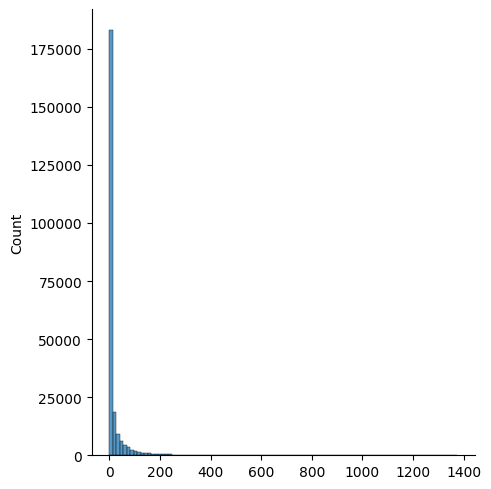

In [44]:
sns.displot(final_preds, bins=100)

In [45]:
pd.read_csv(DATA + "forecast_example.csv", sep=";").columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_weight', 'forecast_wagon_count'],
      dtype='object')

In [46]:
NEEDED_COLUMNS = ['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id', 'forecast_wagon_count']

In [47]:
forecast_example["forecast_wagon_count"] = final_preds
forecast_example = forecast_example[NEEDED_COLUMNS]
forecast_example

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_wagon_count
0,2023-04-01,0,0,0,2275,3291,23976,26423,27983,2.329312
1,2023-04-01,0,0,0,2275,3294,23976,26423,27983,1.614015
2,2023-04-01,0,0,0,2275,3294,23976,24516,27983,1.479148
3,2023-04-01,0,0,0,-1,349,38725,38966,27437,1.252022
4,2023-04-01,0,0,0,-1,349,38754,38966,26664,0.796161
...,...,...,...,...,...,...,...,...,...,...
239600,2023-08-01,1,5,2,1346,1482,31438,31482,0,1.009324
239601,2023-08-01,1,5,2,1346,1492,31438,36091,27275,0.000000
239602,2023-08-01,1,5,2,1346,1492,31438,35450,27275,0.000000
239603,2023-08-01,1,5,2,1346,1492,31438,31482,0,0.956026


In [48]:
forecast_example.columns

Index(['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id',
       'forecast_wagon_count'],
      dtype='object')

In [49]:
forecast_example.to_csv("submission_v2.csv", index=False, sep=";", decimal=",", encoding="windows-1251")